In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('fashion_data.csv')

In [ ]:
df = df.drop(['avg_rating/1'], axis = 1)
df.head()

In [ ]:
def format_date(date):
    date = date.strip()
    date = date.replace(" ", ',')
    date = date.split(',')[::-1]
    months = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
    date[1] = str(months[date[1]])
    return '-'.join(date)

df['date_of_firstrev'] = [format_date(date) for date in df['date_of_firstrev']]
df['date_of_firstrev'].head()

In [ ]:
df = df.rename(columns = {'avg_rating/0':'avg_rating', 'price/0':'price'})
def format_str(n_rev):
    n_rev = n_rev.split()
    for i in n_rev:
        if i.isnumeric():
            return i
    return '0'

df = df[df['no_of_reviews'].notna()]
df['no_of_reviews'] = [format_str(n_rev) for n_rev in df['no_of_reviews']]
df.head()

In [ ]:
# getting first and last dates of our data
lat = ['2020','12','31']
for date in df['date_of_firstrev']:
    date = date.split('-')
    if lat[0]>date[0]:
        lat = date
    elif lat[0]==date[0] and lat[1]>date[1]:
        lat = date
    elif lat[0]==date[0] and lat[1]==date[1] and lat[2]>date[2]:
        lat = date
print(lat)
lat = ['0','0','0']
for date in df['date_of_firstrev']:
    date = date.split('-')
    if lat[0]<date[0]:
        lat = date
    elif lat[0]==date[0] and lat[1]<date[1]:
        lat = date
    elif lat[0]==date[0] and lat[1]==date[1] and lat[2]<date[2]:
        lat = date
print(lat)

In [ ]:
# Lets see how much data do we have for each year
df = df.sort_values(['date_of_firstrev'])
y = df['date_of_firstrev']
y = [date[:4] for date in y]
from collections import Counter
Counter(y)

In [ ]:
print(len(set(df['style'])), set(df['style']), '\n', Counter(df['style']))

In [ ]:
# Let's convert multi-styles variable to single style by considering the first value only
def format_style(style)->str:
    if type(style)==float:
        return 'NULL'
    if  ',' in style:
        return style.split(',')[0]
    return style
df['style'] = [format_style(style) for style in df['style']]
print(len(set(df['style'])), '\n', Counter(df['style']))

In [ ]:
# Due to limited data, I will forecast relative trends for only top 4-5 styles in this notebook
f, ax = plt.subplots(figsize=(11,4))
plt.bar(Counter(df['style']).keys(), Counter(df['style']).values())

In [ ]:
print(Counter(df['season']))

In [ ]:
def format_style(sl)->str:
    if type(sl)==float:
        return 'NULL'
    return sl
df['placket_type'] = [format_style(sl) for sl in df['placket_type']]
f, ax = plt.subplots(figsize=(14,4))
plt.bar(Counter(df['placket_type']).keys(), Counter(df['placket_type']).values())

In [ ]:
# Let's now make a time series forecast for styles
style_df = df[['date_of_firstrev', 'style', 'pttrn_type', 'season', 'avg_rating', 'no_of_reviews']].copy()

In [ ]:
style_df.head()

In [ ]:
style_df = style_df.dropna()
style_df.drop(style_df.loc[style_df['style']=='NULL'].index, inplace=True)

In [ ]:
style_df.head()

In [51]:
print(Counter(style_df['season']))

Counter({'Summer': 1336, 'Winter': 569})


In [52]:
# This result is expected because we are doing analysis on tops. Fashion apparels trending in winter would be jackets, sweaters, etc
# However, I am going to convert it to two-class column. Summer and Summer/Spring will be converted to Summer and rest to Winter
def format(n_season):
    if n_season == 'Summer' or n_season == 'Spring/Summer':
        return 'Summer'
    return 'Winter'

style_df['season'] = [format(n_season) for n_season in style_df['season']]
print(Counter(style_df['season']))

Counter({'Summer': 1336, 'Winter': 569})


In [53]:
# First we have to define a trend score for these products.
# First let's drop the years 2015,2016 and 2017 coz we don't have enough data
style_df = style_df[style_df['date_of_firstrev']>='2018-0-0']

# Now we must cluster all dates month wise, i.e., All days from 2018-01-01 to 2018-01-31 must equal 2018-01
from math import ceil
def format_date(date):
    date = date.split('-')
    date[2] = '01'
    return '-'.join(date)
style_df['date_of_firstrev'] = [format_date(date) for date in style_df['date_of_firstrev']]

In [54]:
print(Counter(style_df['date_of_firstrev']))

Counter({'2019-8-01': 145, '2020-2-01': 144, '2020-3-01': 144, '2019-7-01': 140, '2019-6-01': 130, '2020-5-01': 122, '2019-4-01': 117, '2019-5-01': 109, '2019-9-01': 107, '2020-4-01': 106, '2020-1-01': 88, '2019-10-01': 87, '2019-3-01': 76, '2019-11-01': 62, '2019-12-01': 54, '2020-6-01': 53, '2018-8-01': 29, '2018-11-01': 28, '2019-2-01': 24, '2018-10-01': 21, '2018-9-01': 19, '2018-12-01': 17, '2018-7-01': 15, '2018-5-01': 14, '2018-3-01': 11, '2019-1-01': 11, '2018-4-01': 10, '2018-6-01': 10, '2018-1-01': 5, '2018-2-01': 5, '2020-7-01': 2})


In [55]:
style_df.head()

,date_of_firstrev,style,pttrn_type,season,avg_rating,no_of_reviews
2102,2018-1-01,Casual,Letter,Summer,5.0,0
1367,2018-1-01,Elegant,Plain,Summer,4.8,588
1526,2018-1-01,Boho,Geometric,Winter,4.7,63
168,2018-1-01,Casual,Plain,Winter,4.7,1357
1384,2018-1-01,Casual,Plain,Winter,4.7,3665


In [56]:
# Okay, now I will chose 'Casual' style for my first time series forecasting model
casual_df = style_df[style_df['style']=='Casual']
casual_df.head()

,date_of_firstrev,style,pttrn_type,season,avg_rating,no_of_reviews
2102,2018-1-01,Casual,Letter,Summer,5.0,0
168,2018-1-01,Casual,Plain,Winter,4.7,1357
1384,2018-1-01,Casual,Plain,Winter,4.7,3665
2017,2018-10-01,Casual,Leopard,Winter,4.8,1229
285,2018-10-01,Casual,Striped,Winter,4.4,1551


In [57]:
# Now let's define trend for these products
# Trend = (avg_rating^4)*(no_of_reviews^0.5)
casual_df['Trend'] = casual_df.apply(lambda row: (int(row.avg_rating)**4)*((int(row.no_of_reviews)+1)**0.5), axis = 1)
casual_df.head()

C:\Users\ARCHIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_of_firstrev,style,pttrn_type,season,avg_rating,no_of_reviews,Trend
2102,2018-1-01,Casual,Letter,Summer,5.0,0,625.000000
168,2018-1-01,Casual,Plain,Winter,4.7,1357,9433.869196
1384,2018-1-01,Casual,Plain,Winter,4.7,3665,15500.160515
2017,2018-10-01,Casual,Leopard,Winter,4.8,1229,8978.267093
285,2018-10-01,Casual,Striped,Winter,4.4,1551,10085.230389


In [58]:


print(Counter(casual_df['pttrn_type']))

Counter({'Plain': 242, 'Striped': 83, 'Floral': 41, 'Letter': 31, 'Colorblock': 28, 'Slogan': 24, 'Polka Dot': 20, 'Plaid': 20, 'Geometric': 16, 'Figure': 15, 'Leopard': 14, 'Tie Dye': 14, 'Letter, Floral': 12, 'Animal': 9, 'Plants': 9, 'Cartoon': 8, 'Heart': 8, 'Gingham': 7, 'Graphic': 6, 'All Over Print': 6, 'Camo': 5, 'Houndstooth': 5, 'Cartoon, Letter': 5, 'Ditsy Floral': 5, 'Letter, Figure': 4, 'Tribal': 4, 'Pop Art Print': 4, 'Letter, Graphic': 4, 'Animal, Slogan': 4, 'Letter, Heart': 3, 'Cartoon, Slogan': 3, 'Chain Print': 3, 'Rainbow Stripe': 3, 'Floral, All Over Print': 3, 'Flamingo': 3, 'Tartan': 2, 'Striped, Colorblock': 2, 'Animal, Letter': 2, 'Colorblock, Striped': 2, 'Zebra Stripe': 2, 'Graphic, Letter': 2, 'Letter, Cartoon': 2, 'Graphic, Slogan': 2, 'Floral, Striped': 2, 'Tropical': 2, 'Colorblock, Leopard': 2, 'Letter, Plants': 2, 'Letter, Fruit&Vegetable': 2, 'Floral, Slogan': 2, 'Figure, Letter': 2, 'Letter, Tropical': 2, 'Striped, Plants': 1, 'Chevron, Colorblock': 1

In [59]:
# So here's a lot of classes for Pattern types. We need to reduce them. 
# For starters, I will consider only the first pattern type in case of multiple pattern types
casual_df['pttrn_type'] = [p.split(',')[0] for p in casual_df['pttrn_type']]

def func(p):
    if 'Floral' in p:
        return 'Floral'
    elif 'Letter' in p:
        return 'Letter'
    elif 'Stripe' in p:
        return 'Striped'
    elif 'Plain' in p:
        return 'Plain'
    return 'Others'
casual_df['pttrn_type'] = [func(p) for p in casual_df['pttrn_type']]
print(Counter(casual_df['pttrn_type']))

Counter({'Others': 281, 'Plain': 242, 'Striped': 96, 'Letter': 68, 'Floral': 54})


C:\Users\ARCHIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ARCHIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [60]:
# Let's convert patterns other than Plain, Striped, Letter, Floral

In [61]:
# From each season, I will select top 10 trending products

In [62]:
# Here we have more than 1 time series which influence each other. So we use a multivariate time series forecasting algorithm namely VAR
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [63]:
print(Counter(casual_df['date_of_firstrev']))

Counter({'2019-7-01': 63, '2019-8-01': 61, '2020-5-01': 59, '2020-4-01': 52, '2020-3-01': 48, '2020-2-01': 45, '2019-9-01': 44, '2019-5-01': 42, '2019-6-01': 42, '2019-4-01': 41, '2019-10-01': 35, '2019-3-01': 31, '2020-1-01': 30, '2019-11-01': 24, '2020-6-01': 16, '2018-11-01': 15, '2018-8-01': 14, '2019-12-01': 11, '2018-5-01': 9, '2018-9-01': 9, '2018-10-01': 8, '2019-2-01': 8, '2018-6-01': 7, '2018-3-01': 6, '2018-7-01': 6, '2018-4-01': 4, '2018-1-01': 3, '2018-12-01': 3, '2018-2-01': 3, '2019-1-01': 1, '2020-7-01': 1})


In [64]:
#    So we have two random variables as a function of time - Trend vs Time and Pattern type vs Time.

In [65]:
tdf = casual_df[['date_of_firstrev','pttrn_type','Trend']].copy()
tdf.head()

,date_of_firstrev,pttrn_type,Trend
2102,2018-1-01,Letter,625.000000
168,2018-1-01,Plain,9433.869196
1384,2018-1-01,Plain,15500.160515
2017,2018-10-01,Others,8978.267093
285,2018-10-01,Striped,10085.230389


In [66]:
tdf = (tdf.groupby('date_of_firstrev', as_index=False)
        .agg({'Trend':'mean', 'pttrn_type': lambda x: x.mode()}))

tdf['date_of_firstrev'] =pd.to_datetime(tdf.date_of_firstrev, format="%Y/%m/%d")
tdf = tdf.sort_values(by='date_of_firstrev')
tdf.drop(tdf.tail(2).index,inplace=True)
tdf.set_index('date_of_firstrev', inplace=True)

In [67]:
def func(p):
    if 'Plain' in p:
        return 2
    return 1
tdf['pttrn_type'] = [func(p) for p in tdf['pttrn_type']]


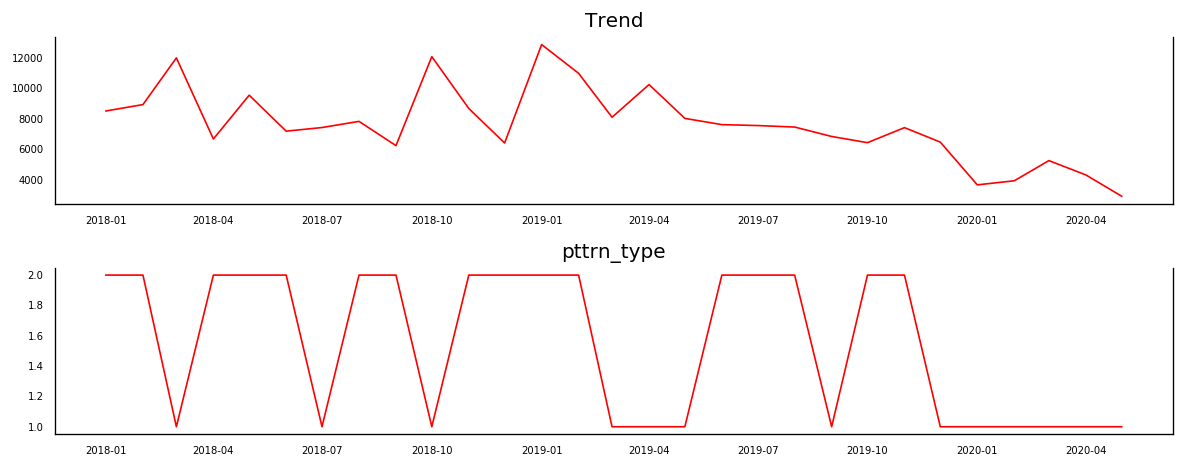

In [68]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    data = tdf[tdf.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(tdf.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [69]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=6
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(tdf, variables = tdf.columns)

,Trend_x,pttrn_type_x
Trend_y,1.0000,0.0
pttrn_type_y,0.0422,1.0


In [70]:
nobs = 4
df_train, df_test = tdf[0:-nobs], tdf[-nobs:]

# Check size
print(df_train.shape)  # (25, 2)
print(df_test.shape)  # (4, 2)

(25, 2)
(4, 2)


In [71]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(tdf, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(tdf,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(tdf.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(tdf)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Trend  ::  11.85     > 12.3212   =>   False
pttrn_type ::  0.5       > 4.1296    =>   False


In [72]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
    

# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Trend" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.4899
 No. Lags Chosen       = 9
 Critical value 1%     = -3.964
 Critical value 5%     = -3.085
 Critical value 10%    = -2.682
 => P-Value = 0.9975. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pttrn_type" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5672
 No. Lags Chosen       = 0
 Critical value 1%     = -3.738
 Critical value 5%     = -2.992
 Critical value 10%    = -2.636
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.




In [73]:
# The results of Johanson's Cointegration test shows that these variables do not have long term relationship

In [74]:
# So, now we remove the pattern_type and build an ARIMA model
tdf = tdf.drop(['pttrn_type'], axis = 1)
tdf.head()

,Trend
date_of_firstrev,
2018-01-01,8519.676570
2018-02-01,8940.518083
2018-03-01,12008.099135
2018-04-01,6680.777430
2018-05-01,9557.524097


In [75]:
tdf = tdf.reset_index()

In [76]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(tdf.Trend.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.550791
p-value: 0.881718


In [77]:
# The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less 
# than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

# So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

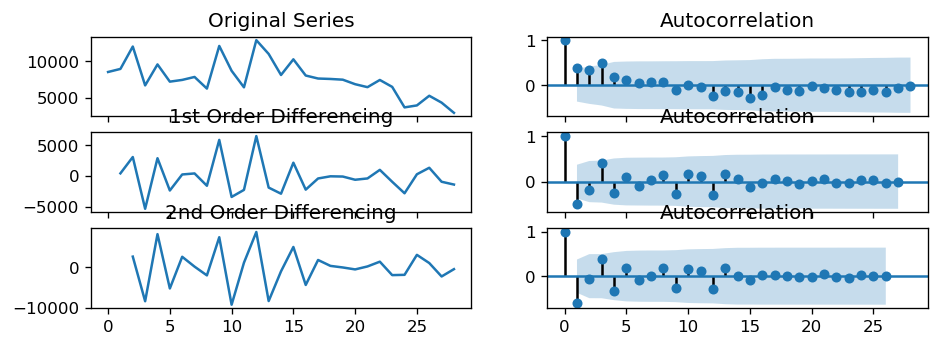

In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(tdf.Trend); axes[0, 0].set_title('Original Series')
plot_acf(tdf.Trend, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(tdf.Trend.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(tdf.Trend.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(tdf.Trend.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tdf.Trend.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

C:\Users\ARCHIT\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


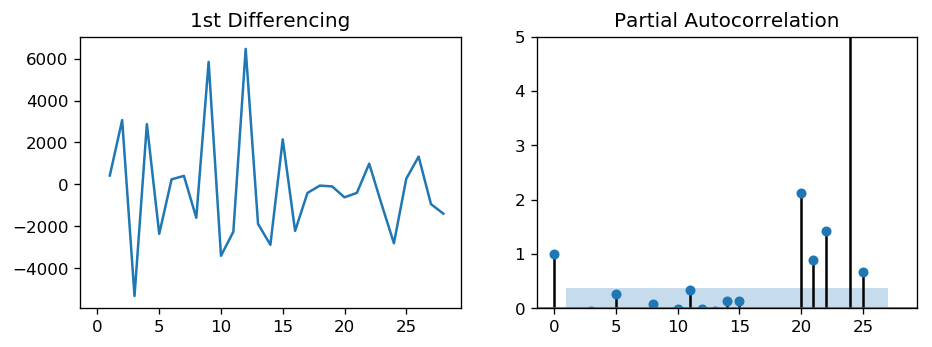

In [79]:
# For the above series, time series reaches stationarity with two orders of differencing

# The next step is to identify if the model needs any AR terms. 
# We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(tdf.Trend.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(tdf.Trend.diff().dropna(), ax=axes[1])

plt.show()

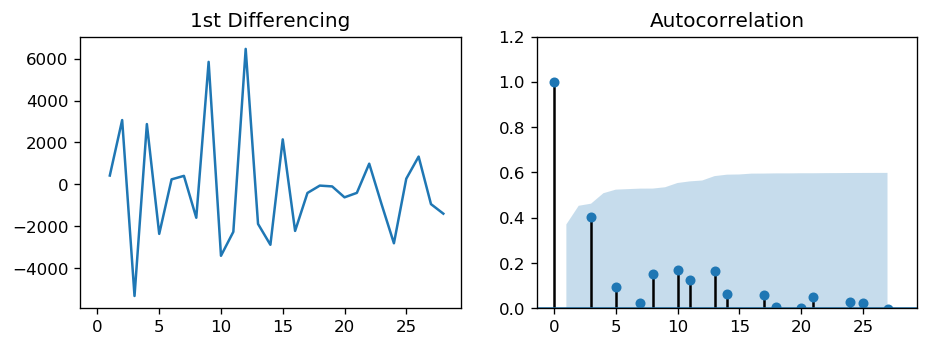

In [80]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(tdf.Trend.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(tdf.Trend.diff().dropna(), ax=axes[1])

plt.show()

In [81]:
from statsmodels.tsa.arima_model import ARIMA

# 1,0,1 ARIMA Model
model = ARIMA(tdf.Trend, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Trend   No. Observations:                   29
Model:                     ARMA(1, 1)   Log Likelihood                -262.143
Method:                       css-mle   S.D. of innovations           2014.815
Date:                Wed, 22 Jul 2020   AIC                            532.286
Time:                        00:24:07   BIC                            537.756
Sample:                             0   HQIC                           533.999
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7177.7916   1473.912      4.870      0.000    4288.978    1.01e+04
ar.L1.Trend     0.9205      0.097      9.482      0.000       0.730       1.111
ma.L1.Trend    -0.6047      0.158     -3.833    

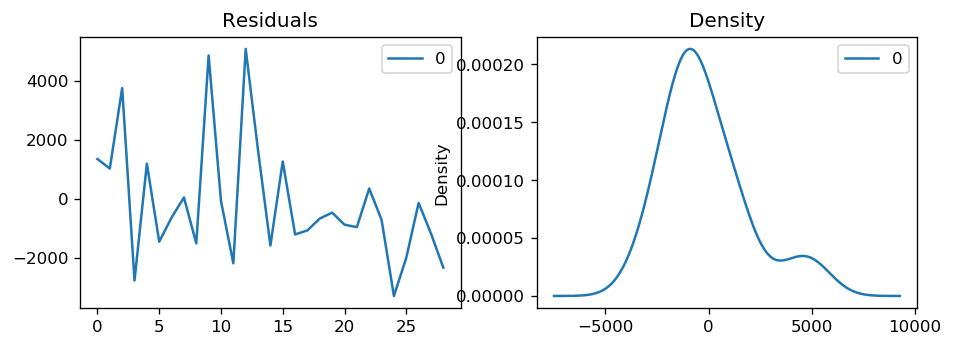

In [82]:
# The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

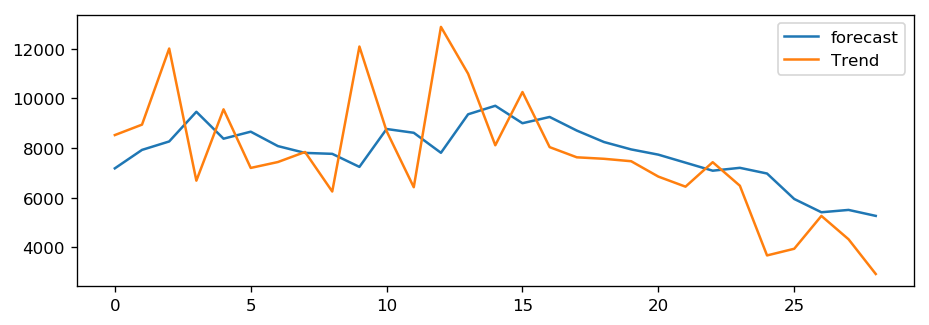

In [83]:
# The residual errors seem fine with near zero mean and uniform variance.
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()


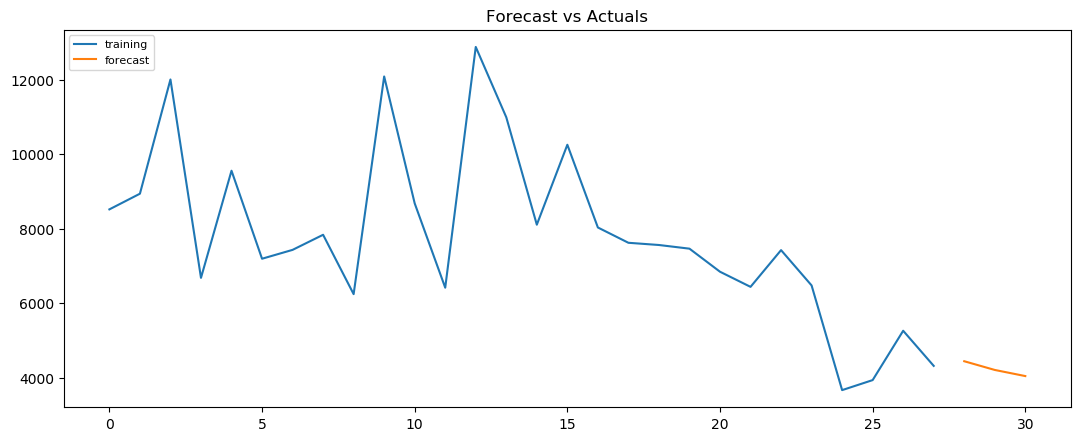

In [104]:
train = tdf.Trend[:28]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, [28,29,30])

# Plot
plt.figure(figsize=(13,5), dpi=100)
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [106]:
######Similarly We have forecasted other styles, features in a seperate notebook